In [2]:
using PyPlot

INFO: Loading help data...


##### Plot functions

In [3]:
function draw_arrow(i::Int64, j::Int64, action::Symbol, dim::(Int64, Int64), changed::Bool)
    NX = dim[2]
    NY = dim[1]+1
    offset = 0.1
    if action == :north
        arrow(i-0.5, NY-j-0.9, 0, +0.3, 0, head_width=0.5, head_length=0.5, lw=1, edgecolor="black", facecolor = (changed?"red":"blue"))
    elseif action == :south
        arrow(i-0.5, NY-j-0.1, 0, -0.3, 0, head_width=0.5, head_length=0.5, lw=1, edgecolor="black", facecolor = (changed?"red":"blue"))
    elseif action == :east
        arrow(i-0.9, NY-j-0.5, +0.3, 0, head_width=0.5, head_length=0.5, lw=1, edgecolor="black", facecolor = (changed?"red":"blue"))
    elseif action == :west
        arrow(i-0.1, NY-j-0.5, -0.3, 0, head_width=0.5, head_length=0.5, lw=1, edgecolor="black", facecolor = (changed?"red":"blue"))
    end
end

function plot_data(maze::Matrix{Char}, policy::Matrix{Symbol}, V::Matrix{Float64}, old_policy::Any)
    s = (size(V)[2]*0.6, size(V)[1] .* 0.25)
    figure(figsize=s)
    subplot(121)
    xticks([])
    yticks([])
    xlim([1,size(V)[2]-1])
    ylim([1,size(V)[1]-1])

    for i = 1:size(V)[2]-2
        plot([i,i],[0,size(V)[1]], color="black")
    end
    for i = 1:size(V)[1]-2
        plot([0,size(V)[2]], [i,i], color="black")
    end
    
    for i = 2:size(V)[1]-1
        for j = 2:size(V)[2]-1
            changed = false
            if old_policy != nothing
                changed = (policy[i, j] != old_policy[i,j])
            end
            draw_arrow(j, i, policy[i, j], size(V), changed)
            #draw_arrow(j, i, :west, size(V))
        end
    end
    subplot(122)
    colorbar(imshow(V[2:end-1,2:end-1], interpolation="none"))
    xticks([])
    yticks([])
    c_values = [v>-100?v:0 for v in V]
    clim([minimum(c_values),maximum(c_values)])
end

plot_data (generic function with 1 method)

##### Convert definition to maze representation

In [4]:
function convert_string_to_string_array(s::String)
    index = 1
    while s[index] == ' ' || s[index] == '\n'
        index = index + 1
    end
    maze = nothing
    row = []
    for i=index:length(s)
        if s[i] == '\n'
            if maze == nothing
                maze = row
            else
                maze = hcat(maze, row)
            end
            row = []
        else
            row = [row, s[i]]
        end
    end
    return maze'
end



function create_experiment_setup(definition::String)
    actions = [:north, :east, :south, :west, :none]

    maze   = convert_string_to_string_array(maze_definition)
    V      = zeros(size(maze))
    policy = reshape([actions[int64(ceil(rand() * (length(actions)-1)))] for i = 1:length(maze)], size(maze))

    for i=1:length(maze)
        if maze[i] in ['#', 'T']
            V[i] = state_reward_function[maze[i]]
            policy[i] = :none
        end
    end

    return maze, policy, V
end

create_experiment_setup (generic function with 1 method)

# Policy iteration

In [5]:
function policy_iteration!(maze::Matrix{Char}, policy::Matrix{Symbol}, V::Matrix{Float64})
    old_policy = copy(policy)
    for i = 2:size(maze)[1]-1
        for j = 2:size(maze)[2]-1
            if maze[i,j] == ' '
                possible_actions = []
                action_values = []
                if maze[i-1,j] != '#'
                    possible_actions = [possible_actions, :north]
                    action_values    = [action_values, V[i-1, j]]
                end
                if maze[i+1,j] != '#'
                    possible_actions = [possible_actions, :south]
                    action_values    = [action_values, V[i+1, j]]
                end

                if maze[i,j-1] != '#'
                    possible_actions = [possible_actions, :west]
                    action_values    = [action_values, V[i, j-1]]
                end
                if maze[i,j+1] != '#'
                    possible_actions = [possible_actions, :east]
                    action_values    = [action_values, V[i, j+1]]
                end
                best_action_value = maximum(action_values)
                possible_actions = possible_actions[findin(action_values,best_action_value)]
                action = possible_actions[int(ceil(rand() * length(possible_actions)))] # random
                policy[i,j] = action
            end
        end
    end
    plot_data(maze, policy, V, old_policy)
end

policy_iteration! (generic function with 1 method)

# Policy evaluation

In [29]:
function policy_evaluation!(maze::Matrix{Char}, policy::Matrix{Symbol}, V::Matrix{Float64})
    old_policy  = copy(policy)
    new_values  = rand(size(V))
    last_values = rand(size(V))
    for i = 2:size(last_values)[1] - 1
        for j = 2:size(last_values)[2] - 1
            if maze[i,j] != ' '
                new_values[i,j] = V[i,j]
                last_values[i,j] = V[i,j]
            end
        end
    end
    δ = 100.0
    index = 0
    γ = 0.9
    while δ > 0.00000001 && index < 5000
        index = index + 1
        for i = 2:size(last_values)[1] - 1
            for j = 2:size(last_values)[2] - 1
                if policy[i,j] == :north
                    new_values[i,j] = γ * (last_values[i-1,j]) - 1.0 # -1.0 for transition
                elseif policy[i,j] == :south
                    new_values[i,j] = γ * (last_values[i+1,j]) - 1.0 # -1.0 for transition
                elseif policy[i,j] == :east
                    new_values[i,j] = γ * (last_values[i,j+1]) - 1.0 # -1.0 for transition
                elseif policy[i,j] == :west
                    new_values[i,j] = γ * (last_values[i,j-1]) - 1.0 # -1.0 for transition
                else
                    new_values[i,j] = γ * last_values[i,j] # terminal states
                end
            end
        end
        δ   = maximum(abs(new_values[2:end-1,2:end-1] .- last_values[2:end-1,2:end-1]))
        last_values = copy(new_values)
    end
    for i=2:size(V)[1] - 1
        for j=2:size(V)[2] - 1
            V[i,j] = new_values[i,j]
        end
    end
    println("Number of iterations: $index, error $δ")
   # plot_data(maze, policy, V, old_policy)    
end

policy_evaluation! (generic function with 1 method)

### Experiment

#### Initialisation & Policy iteration 1

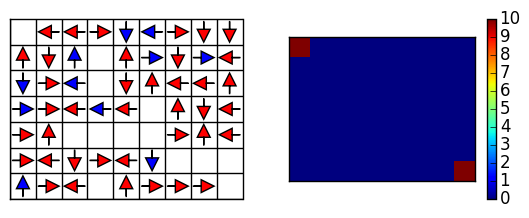

In [34]:
maze_definition = "
###########
#T        #
#   #     #
#   #     #
#     #   #
#  ####   #
#      ####
#   #    T#
###########
"

state_reward_function = ['T' => 10.0, '#' => -100];

maze, policy, V = create_experiment_setup(maze_definition);

policy_iteration!(maze, policy, V)
#plot_data(maze, policy, V, nothing)
#println(V)
#println(policy)

#### Policy <i><u> evaluation </u></i> and <i><u> iteration </u></i> 1

Number of iterations: 198, error 9.677749120240554e-9


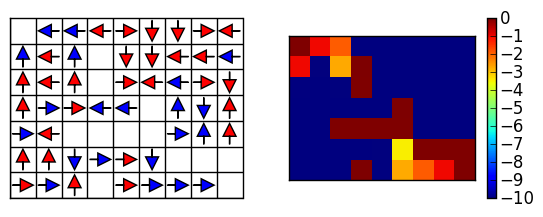

In [35]:
policy_evaluation!(maze, policy, V)
policy_iteration!(maze, policy, V)

#### Policy <i><u> evaluation </u></i> and <i><u> iteration </u></i> 2

Number of iterations: 181, error 9.442549853133642e-9


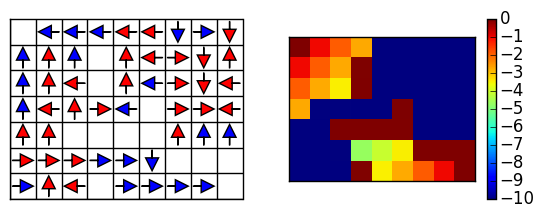

In [36]:
policy_evaluation!(maze, policy, V)
policy_iteration!(maze, policy, V)

#### Policy <i><u> evaluation </u></i> and <i><u> iteration </u></i> 3

Number of iterations: 180, error 9.677775025807023e-9


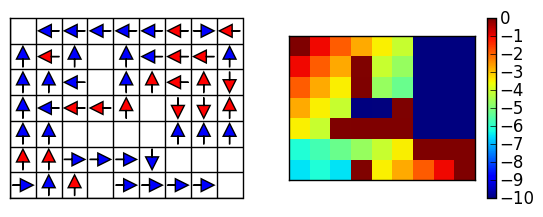

In [37]:
policy_evaluation!(maze, policy, V)
policy_iteration!(maze, policy, V)

#### Policy <i><u> evaluation </u></i> and <i><u> iteration </u></i> 4

Number of iterations: 181, error 9.107587572998455e-9


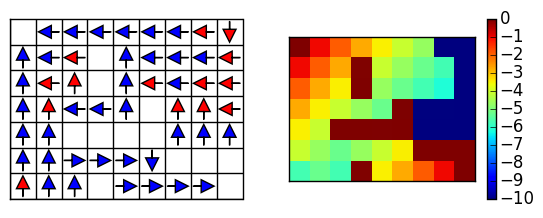

In [38]:
policy_evaluation!(maze, policy, V)
policy_iteration!(maze, policy, V)

#### Policy <i><u> evaluation </u></i> and <i><u> iteration </u></i> 5

Number of iterations: 13, error 3.893741342461356e-34


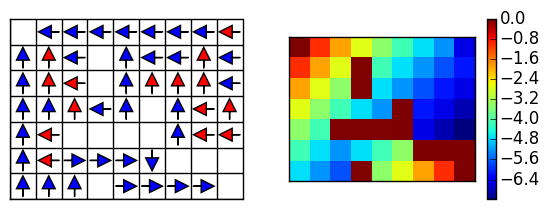

In [39]:
policy_evaluation!(maze, policy, V)
policy_iteration!(maze, policy, V)

#### Policy <i><u> evaluation </u></i> and <i><u> iteration </u></i> 6

Number of iterations: 13, error 7.200309980093026e-42


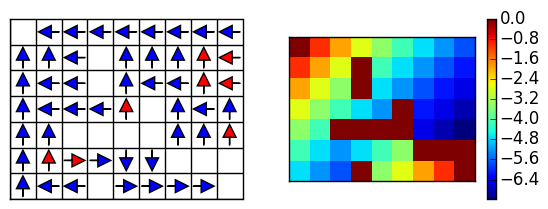

In [52]:
policy_evaluation!(maze, policy, V)
policy_iteration!(maze, policy, V)